COVID19 CT Pneumonia Detection
with Transfer Learning: An implementation in Tensorflow and Keras **bold text**

**1. INITIALIZE THE DATASET**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#set randomness for reproducibility
from numpy.random import seed
seed(8) #1

import tensorflow
tensorflow.random.set_seed(7) #2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os

In [5]:
train_path = 'gdrive/My Drive/PROJECT/AI_110840709_COVID/dataset1/train'
test_path = 'gdrive/My Drive/PROJECT/AI_110840709_COVID/dataset1/test'
print (train_path)
print (test_path)

gdrive/My Drive/PROJECT/AI_110840709_COVID/dataset1/train
gdrive/My Drive/PROJECT/AI_110840709_COVID/dataset1/test


In [6]:
from os import listdir
data_list = listdir('gdrive/My Drive/PROJECT/AI_110840709_COVID/dataset1/train')
#Delete some classes that may interfere
data_list

['covid', 'normal']

**2. INITIALIZE NECESSARY LIBRARY**

(a) Main Library

In [8]:
import numpy as np
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib
from matplotlib import pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import *
%matplotlib inline

Using TensorFlow backend.


(b) Metrics Library

In [9]:
from keras.metrics import binary_crossentropy
from keras.metrics import SpecificityAtSensitivity
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

**3. PREPROCESSING INITIALIZING**

(a) Define Number for Preprocessing Data

In [34]:
IMAGE_SIZE    = (150, 150) 
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 11 # No. of images to be yielded from the generator per batch (try reducing batch size or freeze more layers if your GPU runs out of memory)
NUM_EPOCHS    = 10 # The maximum number of times the program can iterate over the entire dataset in one train
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 #5e-4

#setup the respective training and validation preprocessing and batch image preparation 
#functions using the ImageDataGenerator class, specifying our class_mode parameter as “binary” for this case
#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant'
                                   )                                                 
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(train_path,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary",
                                                 
                                                  )

valid_batches = train_datagen.flow_from_directory(train_path,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary",
                                                  
                                                 
                                                  )

test_batches = train_datagen.flow_from_directory(test_path, 
                                                 target_size=IMAGE_SIZE, 
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 seed=42,
                                                 class_mode="binary"
                                                )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


(b) Layer Modification at Upper Layer of VGG16

Necessary Library

In [53]:
#Simple CNN model based on VGG16
from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization

Masking Images

In [54]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = False


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, trainable=True, activation='relu'))   #Rectified Linear Unit
model.add(layers.Dense(1, trainable=True, activation='sigmoid'))  #Sigmoid activation function

Initializing Necessary Model Compile and Metrics of Preprocessing Value

In [55]:
model.compile(loss='binary_crossentropy',
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc', 
                       keras.metrics.Precision(), 
                       keras.metrics.Recall() 
                       ]
              )

In [56]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None


Compiling Process Preprocessing 

In [57]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                           steps_per_epoch = STEP_SIZE_TRAIN, 
                           validation_data = valid_batches,
                           validation_steps = STEP_SIZE_VALID, 
                           epochs = NUM_EPOCHS
                           
                       )

10
3
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


9/9 [==============================] - 28s 3s/step - loss: 1.1038 - acc: 0.5054 - precision_3: 0.5455 - recall_3: 0.4800 - val_loss: 0.8565 - val_acc: 0.5455 - val_precision_3: 0.5455 - val_recall_3: 1.0000
Epoch 2/10
9/9 [==============================] - 27s 3s/step - loss: 0.6341 - acc: 0.6559 - precision_3: 0.6724 - recall_3: 0.7500 - val_loss: 0.4281 - val_acc: 0.9333 - val_precision_3: 1.0000 - val_recall_3: 0.8889
Epoch 3/10
9/9 [==============================] - 28s 3s/step - loss: 0.3871 - acc: 0.8283 - precision_3: 0.8000 - recall_3: 0.8800 - val_loss: 0.8214 - val_acc: 0.8667 - val_precision_3: 0.7778 - val_recall_3: 1.0000
Epoch 4/10
9/9 [==============================] - 27s 3s/step - loss: 0.3791 - acc: 0.8851 - precision_3: 0.9111 - recall_3: 0.8723 - val_loss: 0.1519 - val_acc: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 5/10
9/9 [==============================] - 27s 3s/step - loss: 0.2195 - acc: 0.9032 - precision_3: 0.8750 - recall_3: 0.9608 - val_l

**4. EVALUATION PLOTTING RESULT**

Graphic Plotting of Preprocessing Metrics

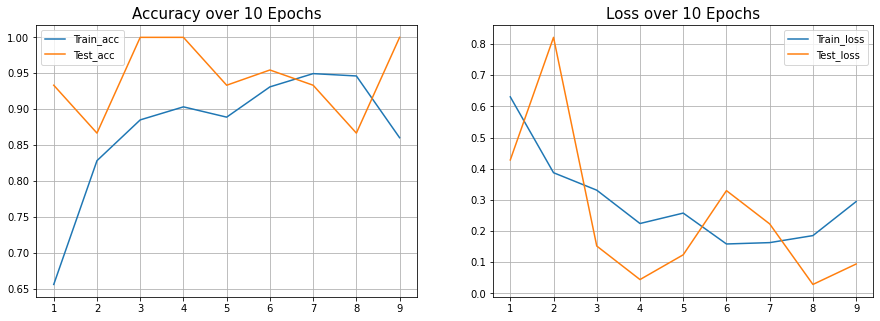

In [58]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, NUM_EPOCHS)

In [62]:
model.save('D1.h5')

TEST AGAIN

In [111]:
#Dont forget shuffle false. Note that Shuffle False is necessary for predict generator due to Keras's internal shuffling.
#But for true accuracy values in evaluate_generator we should use shuffle_true.
#In this case, the accuracy values are the same, but the same IS NOT true for the multiclass case.
#See https://github.com/keras-team/keras/issues/6499

test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size = IMAGE_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = False,
                                                  seed = 42,      
                                                  class_mode = "binary"
                                                  )
eval_generator.reset()

Found 11 images belonging to 2 classes.


In [130]:
eval_generator.reset()
x = model.evaluate_generator(eval_generator,
                             steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                             use_multiprocessing = False,
                             verbose = 1,
                             workers = 1

                             )

print('Test loss:' , x[0])
print('Test accuracy:',x[1])

1/1 [==============================] - 3s 3s/step
Test loss: 0.10330473631620407
Test accuracy: 1.0


**5. PREDICTION**

From Test Batches

In [131]:
eval_generator.reset()  
pred = model.predict_generator(eval_generator, steps=1, verbose=1)
print("Predictions finished")
print(pred)

1/1 [==============================] - 3s 3s/step
Predictions finished
[[0.23204258]
 [0.15493783]
 [0.00651449]
 [0.05315214]
 [0.01198271]
 [0.00650439]
 [0.90947616]
 [0.68468136]
 [0.93048596]
 [0.96475106]
 [0.95826495]]


In [132]:
j=0
y=0
for i in pred:
    if i > 0.5:
        j=j+1
    else:
        y=y+1
print('Normal:',j)    
print('COVID19 :',y)

y_pred = np.where(pred > 0.5, 1, 0)
y_pred = y_pred[:,0]
print(y_pred)

Normal: 5
COVID19 : 6
[0 0 0 0 0 0 1 1 1 1 1]


In [133]:
y_true = eval_generator.classes
print(y_true)
print(y_pred)

[0 0 0 0 0 0 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 1 1]


In [134]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



**6. METRICS FINAL RESULT**

Calculating Our Prediction from Train and Test

In [135]:
cm = confusion_matrix(y_true, y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[6 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


Confusion Matrix, without normalization


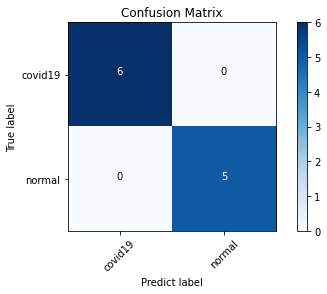

In [136]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

cm_plot_labels = ['covid19','normal']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [143]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  6
False Positives:  0
False Negatives:  0
True Positives:  5


In [144]:
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("acc: {:.4f}".format(Accuracy))

#Precision 
Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))

#Recall 
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

#F1 Score
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))

#F-beta score calculation
def fbeta(precision, recall, beta):
    return ((1+pow(beta,2))*precision*recall)/(pow(beta,2)*precision + recall) 

f2 = fbeta(Precision, Recall, 2)
f0_5 = fbeta(Precision, Recall, 0.5)

print("F2 {:0.2f}".format(f2)) 
print("F0.5 {:0.2f}".format(f0_5))

#Specificity 
Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))

acc: 100.0000
Precision 1.00
Recall 1.00
F1 Score 1.00
F2 1.00
F0.5 1.00
Specificity 1.00


**7. PLOTTING IMAGES BY RESULT**

In [140]:
eval_generator.reset()  
pred2 = model.predict_generator(eval_generator, BATCH_SIZE, verbose=1)
print("Predictions finished")

11/11 [==============================] - 29s 3s/step
Predictions finished


covid/nejmoa2001191_f4.jpeg


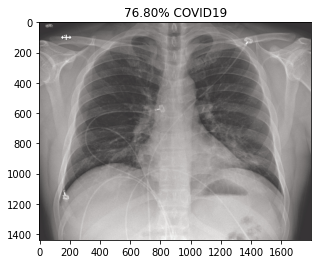

covid/nejmoa2001191_f5-PA.jpeg


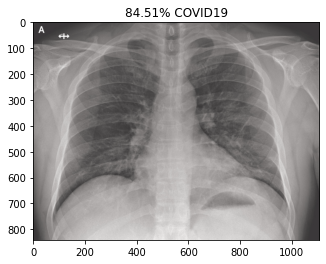

covid/radiol.2020200490.fig3.jpeg


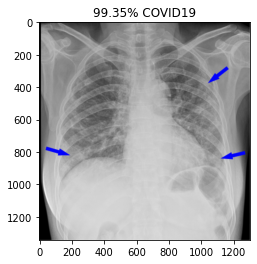

covid/ryct.2020200034.fig2.jpeg


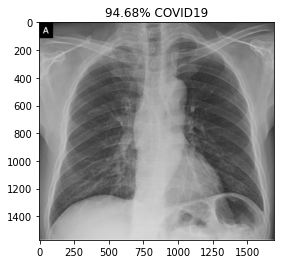

covid/ryct.2020200034.fig5-day0.jpeg


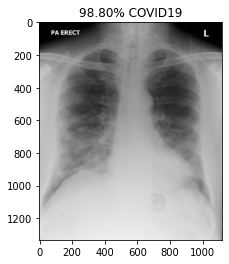

covid/ryct.2020200034.fig5-day4.jpeg


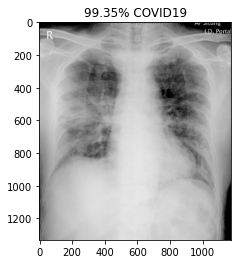

normal/NORMAL2-IM-1385-0001.jpeg


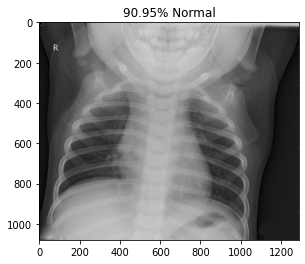

normal/NORMAL2-IM-1396-0001.jpeg


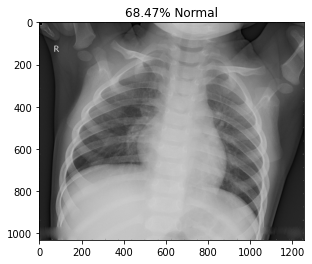

normal/NORMAL2-IM-1400-0001.jpeg


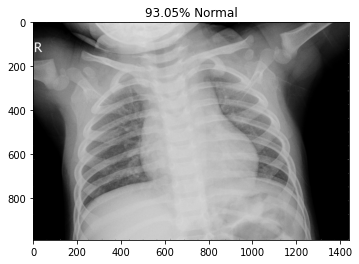

normal/NORMAL2-IM-1401-0001.jpeg


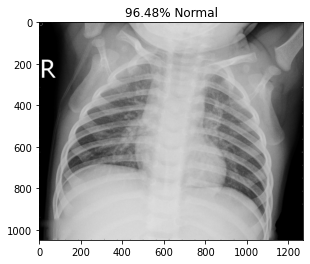

normal/NORMAL2-IM-1422-0001.jpeg


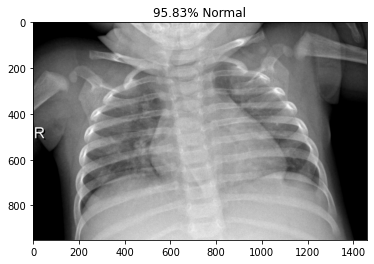

IndexError: ignored

In [141]:
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred2):
  image_path = test_path + "/" + eval_generator.filenames[index]
  image = mpimg.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  pixels = np.array(image)
  plt.imshow(pixels)

  print(eval_generator.filenames[index])
  if probability > 0.5:
    plt.title("%.2f" % (probability[0]*100) + "% Normal")
  else:
    plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19")
  plt.show()